In [1]:
! pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 28.1 MB/s 
     |████████████████████████████████| 216 kB 61.7 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=c9bf5dc3e978d67cad660f55fd8e33b243170e81df962eafd74535b5cebfe828
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [2]:
import networkx as nx
from networkx.drawing import nx_agraph
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import stanza
import nltk
from nltk.tree import Tree

import matplotlib.pyplot as plt

In [3]:
# Build a Neural Pipeline
stanza.download('en')
StanzaPipeline = stanza.Pipeline('en', processors = "tokenize,pos,lemma,depparse,constituency") 

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| lemma        | combined |
| depparse     | combined |
| constituency | wsj      |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: constituency
INFO:stanza:Done loading processors!


In [4]:
def C_tree_to_dot(t):
    """
    input :
    t =  NLTK Tree, 
    
    returns :
    s = a dot representation, suitable for using with Graphviz
    (type(s) = string for Python)
    """
    def gv_print(t,start_node=1):
        """
        Print the tree for a defined node. Nodes are specified in-order in the original tree	
        """
        # Print the start node of the tree
        s ='%s [label="%s"]' % (start_node,t.label())
        pos=start_node+1


        for child in t:
            if isinstance(child,nltk.tree.Tree): # the node is the root of a subtree ( non terminal )
                (s_child,newpos)=gv_print(child,pos)
                s=s+'\n'+ s_child
                s=s+'\n%s -> %s [dir=none]' % (start_node,pos)
                pos=newpos
            elif isinstance(child, str):  # the node is a leaf ( terminal )
                s=s+'\n%s [label="%s"]' % (pos,child)
                s=s+'\n%s -> %s' % (start_node,pos)	
            pos+=1
        return (s,pos-1)

    # Print the digraph dot specification
    s='digraph G{\n'	
    s+=gv_print(t)[0]
    s+="\n}"

    return s

In [5]:
def dot_to_nxgraph(path):
    """
    input :
    - path = directory + filename, filename is the name of the saved dot file
    
    returns :
    - final_G1 = a NeworkX Digraph, not rooted
    """
    G1 = nx.Graph(nx.nx_pydot.read_dot(path))
    label1 = nx.get_node_attributes(G1, 'label')
    final_G1 = nx.DiGraph()
    
    for vertex in G1.nodes.data('label'):
        final_G1.add_node(vertex[0], label=vertex[1])
    for edge in G1.edges.data():
        final_G1.add_edge(edge[0], edge[1])

    return final_G1

In [9]:
def graph_n_tree(phrase, path, display=False):
  """
  input : 
  - phrase = string sentence
  - path =  directory + filename, filename is the name of the saved dot file
  - display = if True, displays the NLTK tree

  returns :
  - sent_dico = Stanza dictionnary https://stanfordnlp.github.io/stanza/data_objects.html#document
  - dot_tree = the dot file (type(dot_tree) = string for Python),
  - G = a NetworkX Directed Graph
  - T = a NetworkX Tree
  """
  doc = StanzaPipeline(phrase) #Stanza.Document
  sentence = doc.sentences[0]  #Stanza.Sentence
  sent_dico = sentence.to_dict()  #dictionnary
  stanza_tree = sentence.constituency #Stanza.Tree
  nltk_tree = Tree.fromstring(str(stanza_tree)) #NLTK.Tree

  if display :
    nltk_tree.pretty_print()

  dot_tree = C_tree_to_dot(nltk_tree)
  f = open(path+'.dot', 'w')
  f.write(dot_tree)
  f.close()
  G = dot_to_nxgraph(path+'.dot')
  T = nx.dfs_tree(G, source='1',)
  nx.set_node_attributes(T, dict(G.nodes(data=True)))

  return sent_dico, dot_tree, G, T

## Example

In [7]:
sentence = "A brown and white dog is playing on the grass"

In [11]:
sentence_dictionnary, dot, graph, tree = graph_n_tree(sentence, 'test', display=True)

                     ROOT                                  
                      |                                     
                      S                                    
            __________|________________                     
           |                           VP                  
           |                ___________|___                 
           |               |               VP              
           |               |      _________|___             
           NP              |     |             PP          
  _________|__________     |     |      _______|___         
 |        ADJP        |    |     |     |           NP      
 |     ____|_____     |    |     |     |        ___|____    
 DT   JJ   CC    JJ   NN  VBZ   VBG    IN      DT       NN 
 |    |    |     |    |    |     |     |       |        |   
 A  brown and  white dog   is playing  on     the     grass



In [12]:
def plot_tree(T1, path):
  """
  input :
  - T1 = a NetorkX tree,
  - path = directory + filename

  returns :
  None, saves a png @ path
  """

  plt.figure(figsize=(8,8))
  pos = graphviz_layout(T1, prog="dot")
  f = nx.draw_networkx(T1, pos, arrows=False, with_labels=True, font_size=8) 
  f = nx.draw_networkx_labels(T1, pos, nx.get_node_attributes(T1, 'label'), verticalalignment='bottom', horizontalalignment='right', font_size=13, font_color='r',)
  plt.savefig(path+'.png')

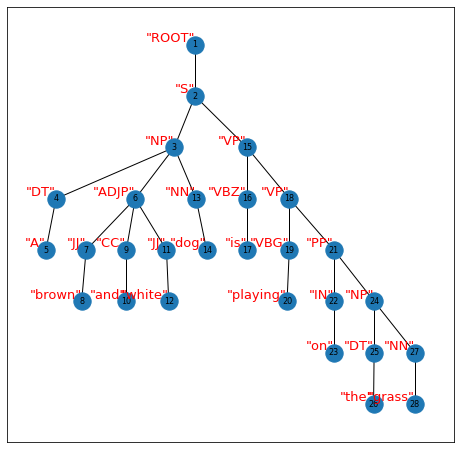

In [13]:
plot_tree(tree, 'graph' )